# **Stock Sentiment Analysis – Model Evaluation and Testing**

This notebook investigates various machine learning techniques and models for sentiment analysis of stock-related tweets, with the objective of identifying the most effective model for accurate sentiment prediction. Its companion notebook — see `tm_final_20.ipynb` — applies the selected model to the problem context to generate final predictions.

## 0. Imports

In [ ]:
# Standard Library
import os
import re

# Local Scripts
os.chdir("../scripts")

# Constants
from constants import (
    TRAIN_DATA, 
    TEST_DATA, 
    LABELS, 
    DATA_DIR,
    NLTK_DATA,
    GENSIM_DATA
) #type: ignore

# Auxiliaries
from aux_funcs import (
    find_punctuated_tokens, 
    eval_sklearn_model, 
    eval_lstm_model,
    eval_llm_model, 
    eval_transformer
) #type: ignore

# Data Preprocessor
from preprocessor import preprocess #type: ignore

# Local Classes
os.chdir("../classes")
from classes import W2VVectorizer, CLSVectorizer, BERTVectorizer

# Standard Data Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Wordclound Visualization
from wordcloud import WordCloud

# Modelling and modelling metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Transformers
from transformers import AutoTokenizer, AutoModel

# Natural Language ToolKit
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# General Similarity - NLP - Pre-trained Models
from gensim.models import Word2Vec
import gensim.downloader as api

/home/shadybea/anaconda3/envs/tm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-15 10:36:05.783534: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 10:36:05.797745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749980165.814573   57874 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749980165.819410   57874 cuda_blas.cc:140

In [2]:
# Download if not data not found
if not os.path.isdir(NLTK_DATA):
    nltk.download('stopwords', download_dir=NLTK_DATA)
    nltk.download('wordnet', download_dir=NLTK_DATA)

nltk.data.path.append(NLTK_DATA)

## 1. Data Loading

In [3]:
train_data = pd.read_csv(TRAIN_DATA)
test_data = pd.read_csv(TEST_DATA)

In [4]:
train_data.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [5]:
test_data.head()

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


## 2. Data Exploration

In [6]:
# Checking for missing values
train_data.isna().sum()

text     0
label    0
dtype: int64

There are no missing values in the dataset, so it is safe to proceed.

### 2.1. Text Feature

#### 2.1.1. Word Count

Start by spliting `text` into tokens and analysing the number of tokens in each document.

In [7]:
# Fetch wordcount for each document
train_data['word_count']  = train_data['text'].apply(lambda x: len(str(x).split(" ")))
train_data[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


#### 2.1.2. Descriptive Statistics

In [8]:
train_data['word_count'].describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

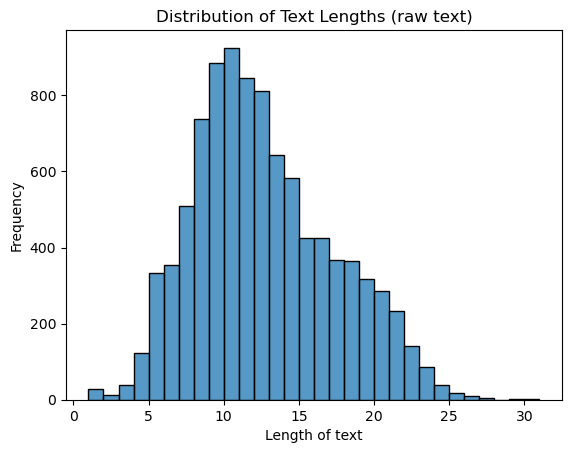

In [9]:
#Plot distribution of text length
sns.histplot(train_data['word_count'], bins=30)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

Considering the table and plot above, it is evident that some rows have very few words. Below, is a deeper exploration of these cases.

In [10]:
# Checking records with 3 words or less
train_data[train_data['word_count'] <= 3]

,text,label,word_count
1858,SASA聚酯选用英威达PTA技术,2,1
3090,Brent +4%,1,2
3593,Honeywell reaffirms guidance,2,3
3943,:),2,1
3945,@MikeCaymanTrades sometimes,2,2
...,...,...,...
8805,SBFGP,2,1
8866,took $PANW #4,2,3
8867,took $PLAY #4,2,3
8878,WBK,2,1


Looking at the records with 3 or less words, most belong to the Neutral category (label = 2). Since there is an overrepresentation of this class in the dataset, below the records above belonging to the Neutral category are excluded.

In [11]:
train_data = train_data[~((train_data['word_count'] <= 3) & (train_data['label'] == 2))]

In [12]:
# Checking word frequency
all_words = ' '.join(train_data['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2331
the    1820
of     1464
-      1390
in     1361
on     1134
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

From the table above, "the" and "The" are both words in the top 10 - this could indicate a beneficial effect of lowercasing the 'text' feature.<br>
Also, "-" is a very common symbol which has no meaning and should be removed from the feature.

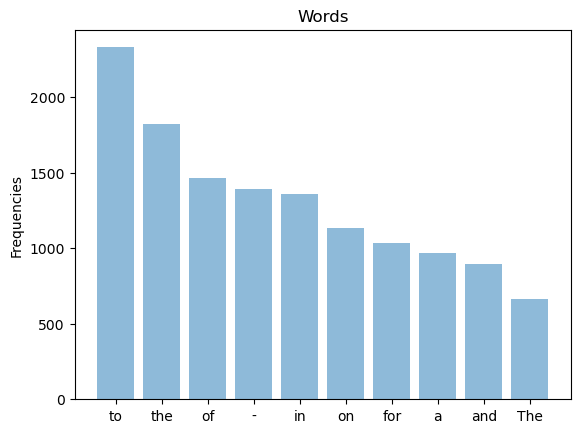

In [13]:
# Plotting the word frequencies count
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')

plt.show()

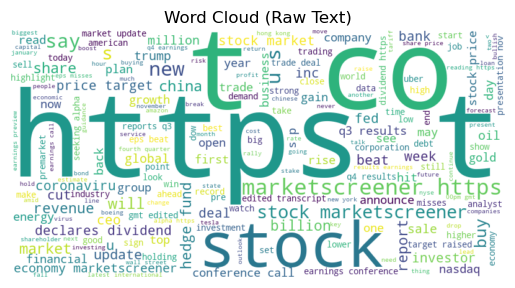

In [14]:
# Create a word cloud from the text feature
raw_text = ' '.join(train_data['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

### 2.2. Target Feature

In [15]:
train_data['label'].value_counts()

label
2    6108
1    1923
0    1442
Name: count, dtype: int64

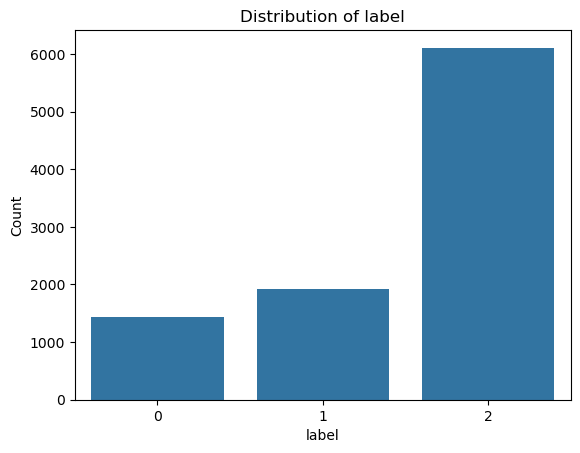

In [16]:
# Visualize distribution of label
sns.countplot(data=train_data, x='label')
plt.title("Distribution of label")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

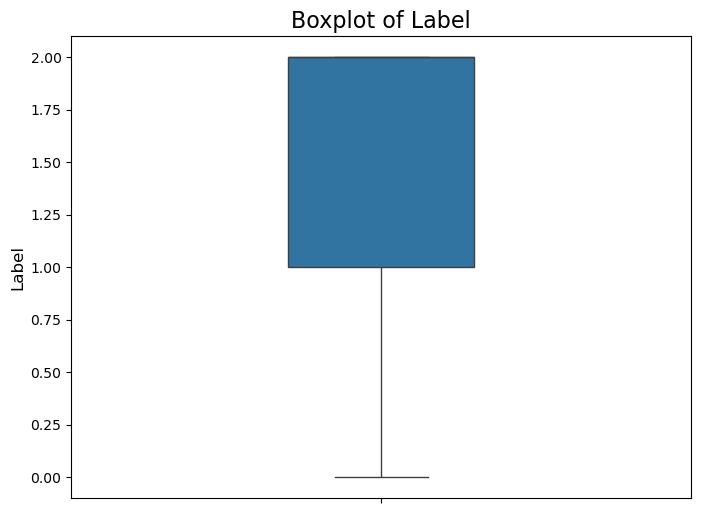

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(y='label', data=train_data, width=0.3)

plt.title('Boxplot of Label', fontsize=16)
plt.ylabel('Label', fontsize=12)
plt.xlabel('')

plt.show()

## 3. Data Preprocessing

In [18]:
# Defining the stopwords
stop = set(stopwords.words('english'))

# Initializing Lemmatizer
lemma = WordNetLemmatizer()

# Initializing Stemmer
stemmer = SnowballStemmer('english')

In [19]:
# Apply preprocessing
train_data['text'] = preprocess(
    corpus=train_data['text'],
    stopwords=stop,
    lemmatizer=lemma
)

In [20]:
# Apply preprocessing
test_data['text'] = preprocess(
    corpus=test_data['text'],
    stopwords=stop,
    lemmatizer=lemma
)

In [21]:
# Export preprocessed data
train_data.to_csv(f'{DATA_DIR}/train_preprocessed.csv', sep=',', index=False)
test_data.to_csv(f'{DATA_DIR}/test_preprocessed.csv', sep=',', index=False)

In [18]:
# Reassign datasets
train_data = pd.read_csv(f'{DATA_DIR}/train_preprocessed.csv')
test_data = pd.read_csv(f'{DATA_DIR}/test_preprocessed.csv')

In [19]:
# Fill missing values with empty string
train_data['text'] = train_data['text'].fillna('')
test_data['text'] = test_data['text'].fillna('')

### 3.1. Rechecking the Plots

In [20]:
all_words = ' '.join(train_data['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

stock       687
market      374
new         357
price       345
earnings    343
report      342
update      294
inc         279
dividend    269
share       262
Name: count, dtype: int64

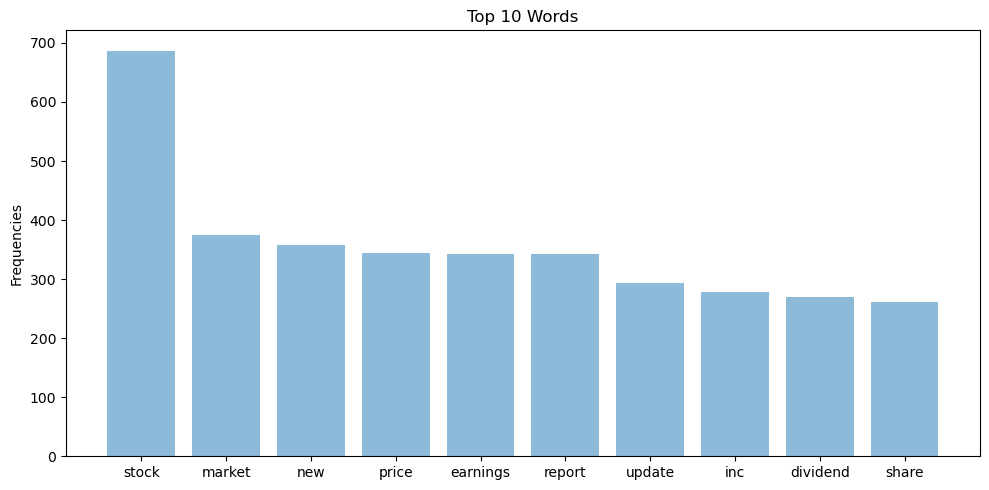

In [21]:
plt.figure(figsize=(10, 5))
x_labels = freq.index[0:10]
values = freq[:10]

plt.bar(x_labels, values, align='center', alpha=0.5)
plt.ylabel('Frequencies')
plt.title('Top 10 Words')
plt.tight_layout()

plt.show()

In [22]:
# Drop rows with encoding errors
exceptions = find_punctuated_tokens(train_data['text'])

pattern = r'(?:' + '|'.join(re.escape(word) for word in exceptions) + r')'

train_data = train_data[~train_data['text'].str.contains(pattern, case=False, na=False)]

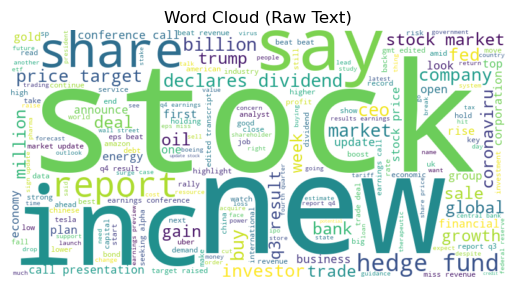

In [23]:
# Word cloud
raw_text = ' '.join(train_data['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [24]:
# Define dependent and independent features

# Train
X_train = train_data['text']
y_train = train_data['label']

# Test
X_test = test_data['text']

In [25]:
train_data.head()

,text,label,word_count
0,jpmorgan reel expectation beyond meat,0,10
1,nomura point booking weakness carnival royal c...,0,14
2,cemex credit suisse morgan weak building outlook,0,14
3,btig research neutral,0,7
4,funko slide piper jaffray cut,0,10


## 4. Feature Engineering

### 4.1 Bag of Words

In [26]:
# Bag of Words
bow = CountVectorizer(
    binary=True  # using binary=True, because working with short text
)

### 4.2 Word2Vec

In [27]:
w2v = W2VVectorizer(
    Word2Vec(
        sentences=train_data.text.apply(lambda x: x.split()).tolist(), #list of lists
        vector_size=5,    # size of the embedding vectors
        window=2,         # context window size
        min_count=1,      # minimum word frequency to include
        sg=1              # 1 for skip-gram; 0 for CBOW
    )
)

### 4.3. DistilBERT

In [28]:
distilbert_model = "distilbert-base-uncased-finetuned-sst-2-english"
distilbert = CLSVectorizer(
    embeddings_model=BERTVectorizer(
        model_name=distilbert_model
    ).embed
)

### 4.4. RoBERTa

In [29]:
roberta_model = "cardiffnlp/twitter-roberta-base-sentiment"
roberta = CLSVectorizer(
    embeddings_model=BERTVectorizer(
        model_name=roberta_model
    ).embed
)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.5. FinBERT

In [30]:
finbert_model = "yiyanghkust/finbert-tone"
finbert = CLSVectorizer(
    embeddings_model=BERTVectorizer(
        model_name=finbert_model
    ).embed
)

## 5. Modelling

In [32]:
# Stratified K-Fold
skf = StratifiedKFold(
    n_splits=5
    ,shuffle=True
    ,random_state=20
)

### 5.1. KNN

In [32]:
knn = KNeighborsClassifier(
    n_neighbors=10
    ,metric='cosine'
    ,weights='distance'
)

#### Bag of Words

In [33]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=bow
    ,classifier=knn
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [34]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.6480    0.3616    0.4641      1441
     Bullish     0.5920    0.5978    0.5949      1922
     Neutral     0.8078    0.8897    0.8468      6095

    accuracy                         0.7499      9458
   macro avg     0.6826    0.6164    0.6353      9458
weighted avg     0.7396    0.7499    0.7373      9458



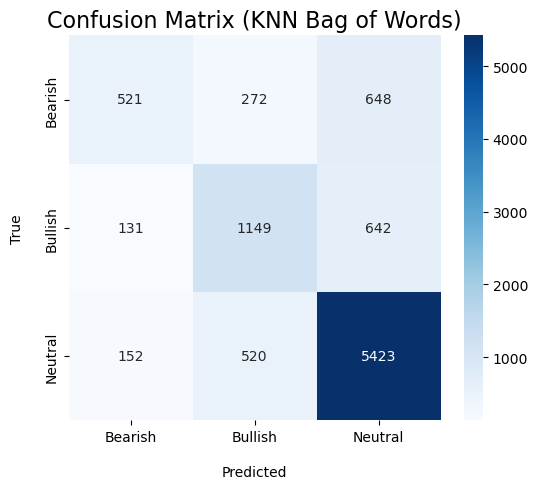

In [35]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN Bag of Words)', fontsize=16)
plt.show()

#### Word2Vec

In [36]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=w2v
    ,classifier=knn
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

In [37]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.3165    0.1520    0.2053      1441
     Bullish     0.4332    0.3039    0.3572      1922
     Neutral     0.7087    0.8625    0.7781      6095

    accuracy                         0.6407      9458
   macro avg     0.4861    0.4394    0.4469      9458
weighted avg     0.5930    0.6407    0.6053      9458



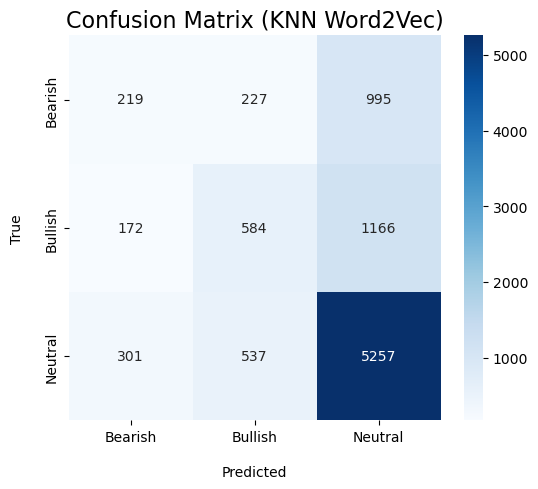

In [38]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN Word2Vec)', fontsize=16)
plt.show()

#### DistilBERT

In [39]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=distilbert,
    classifier=knn,
    skf=skf,
    X_train=X_train,
    y_train=y_train
)

100%|██████████| 1891/1891 [00:42<00:00, 44.16it/s]


In [40]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.5192    0.5253    0.5222      1441
     Bullish     0.6029    0.5016    0.5476      1922
     Neutral     0.7919    0.8317    0.8113      6095

    accuracy                         0.7179      9458
   macro avg     0.6380    0.6195    0.6270      9458
weighted avg     0.7119    0.7179    0.7137      9458



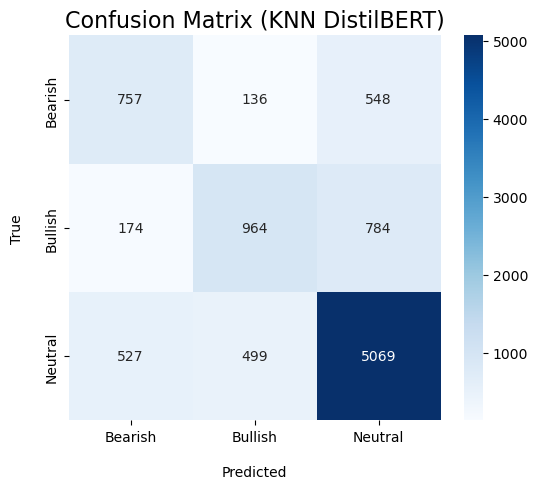

In [41]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN DistilBERT)', fontsize=16)
plt.show()

#### RoBERTa

In [42]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=roberta,
    classifier=knn,
    skf=skf,
    X_train=X_train,
    y_train=y_train
)

100%|██████████| 1891/1891 [01:27<00:00, 21.53it/s]


In [43]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.6143    0.5503    0.5805      1441
     Bullish     0.6845    0.5983    0.6385      1922
     Neutral     0.8172    0.8697    0.8426      6095

    accuracy                         0.7659      9458
   macro avg     0.7053    0.6728    0.6872      9458
weighted avg     0.7593    0.7659    0.7612      9458



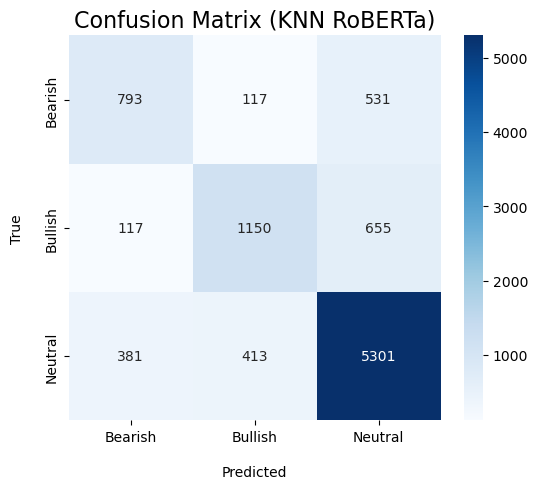

In [44]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN RoBERTa)', fontsize=16)
plt.show()

#### FinBERT

In [45]:
# Evaluate the model
y_true_all, y_pred_all = eval_sklearn_model(
    vectorizer=finbert,
    classifier=knn,
    skf=skf,
    X_train=X_train,
    y_train=y_train
)

100%|██████████| 1891/1891 [01:24<00:00, 22.30it/s]


In [46]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.6359    0.4740    0.5431      1441
     Bullish     0.6845    0.5578    0.6147      1922
     Neutral     0.8029    0.8981    0.8478      6095

    accuracy                         0.7643      9458
   macro avg     0.7078    0.6433    0.6685      9458
weighted avg     0.7534    0.7643    0.7540      9458



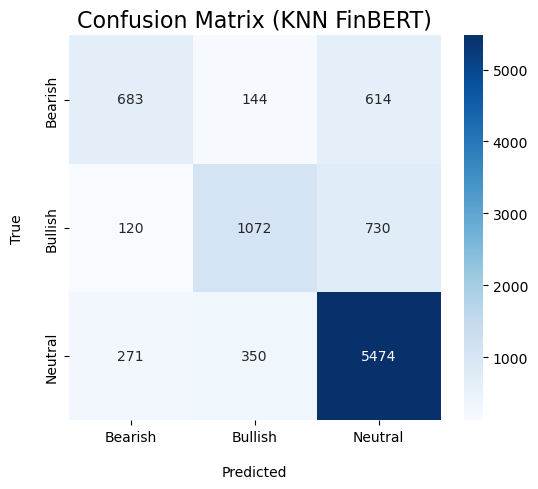

In [47]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (KNN FinBERT)', fontsize=16)
plt.show()

### 5.2. LSTM

#### Word2Vec

In [33]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    X_train=X_train,
    y_train=y_train,
    skf=skf,
    emb_method="word2vec",
    emb_model=w2v,
    device='cpu'
)

Epoch 1/5


I0000 00:00:1749980193.487972   57963 service.cc:152] XLA service 0x74973c00c6b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749980193.487997   57963 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-06-15 10:36:33.583405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/237 ━━━━━━━━━━━━━━━━━━━━ 14:00 4s/step - accuracy: 0.5625 - loss: 1.2041

I0000 00:00:1749980194.662188   57963 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.4326 - loss: 1.0647 - val_accuracy: 0.5137 - val_loss: 1.0241
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.5475 - loss: 1.0172 - val_accuracy: 0.5037 - val_loss: 1.0145
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.5541 - loss: 1.0074 - val_accuracy: 0.5190 - val_loss: 0.9979
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.5540 - loss: 0.9977 - val_accuracy: 0.5069 - val_loss: 0.9987
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5586 - loss: 0.9903 - val_accuracy: 0.5106 - val_loss: 0.9861
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.4226 - loss: 1.0682 - val_accuracy: 0.4937 - val_loss: 1.0442
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.5425 - loss: 1.0271 - val_accuracy: 0.5196 - val_loss: 1.0125
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.

In [34]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.2098    0.3761    0.2694      1441
     Bullish     0.3805    0.3892    0.3848      1922
     Neutral     0.7908    0.6369    0.7056      6095

    accuracy                         0.5468      9458
   macro avg     0.4604    0.4674    0.4532      9458
weighted avg     0.6189    0.5468    0.5739      9458



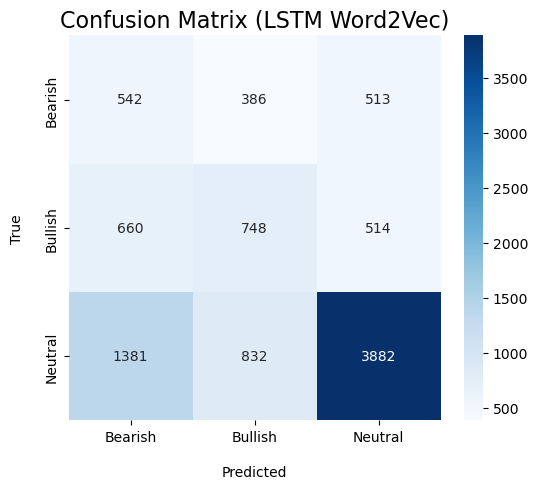

In [35]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM Word2Vec)', fontsize=16)
plt.show()

In [36]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

,fold,epoch,accuracy,loss,val_accuracy,val_loss
0,0,1,0.497753,1.049714,0.513742,1.024105
1,0,2,0.537536,1.023241,0.503700,1.014495
2,0,3,0.540708,1.012960,0.519027,0.997943
3,0,4,0.541369,1.004186,0.506871,0.998677
4,0,5,0.540180,0.997262,0.510571,0.986100


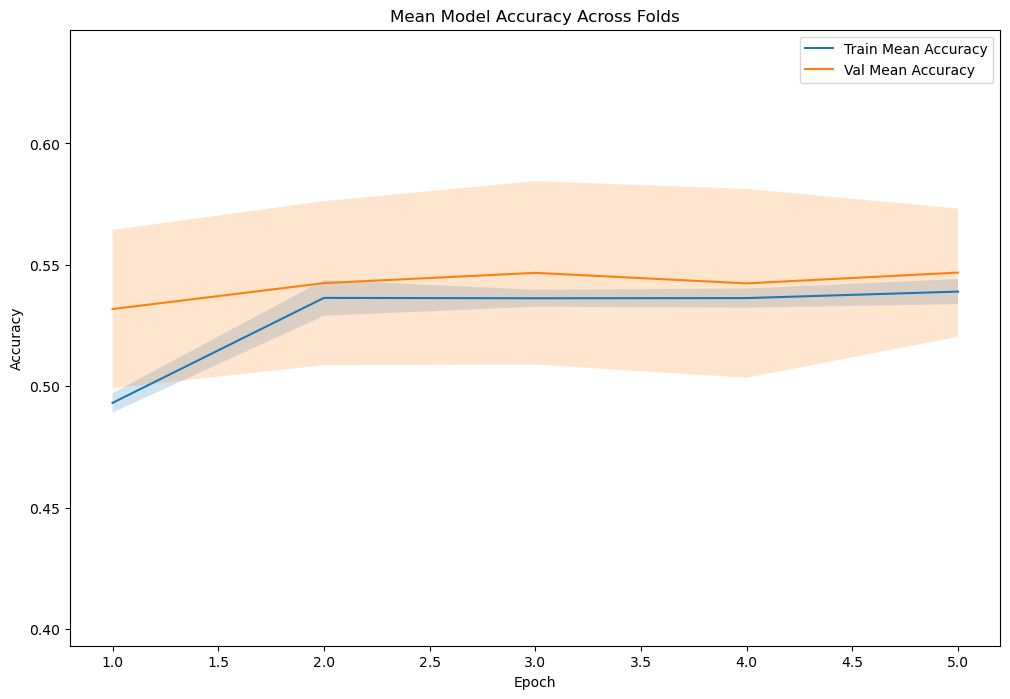

In [37]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### DistilBERT

In [38]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    X_train=X_train,
    y_train=y_train,
    skf=skf,
    emb_method="transformer",
    emb_model=AutoModel.from_pretrained(distilbert_model),
    tokenizer=AutoTokenizer.from_pretrained(distilbert_model),
    device='cuda'
)

100%|██████████| 1892/1892 [00:14<00:00, 133.01it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 293ms/step - accuracy: 0.5353 - loss: 0.9978 - val_accuracy: 0.7077 - val_loss: 0.7369
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 63s 267ms/step - accuracy: 0.6402 - loss: 0.8216 - val_accuracy: 0.6956 - val_loss: 0.7232
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 63s 266ms/step - accuracy: 0.6591 - loss: 0.7711 - val_accuracy: 0.6564 - val_loss: 0.7801
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 63s 265ms/step - accuracy: 0.6836 - loss: 0.7152 - val_accuracy: 0.6771 - val_loss: 0.7380
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 63s 265ms/step - accuracy: 0.7128 - loss: 0.6591 - val_accuracy: 0.6876 - val_loss: 0.7258
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step


100%|██████████| 1892/1892 [00:14<00:00, 130.70it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step - accuracy: 0.5530 - loss: 0.9754 - val_accuracy: 0.6723 - val_loss: 0.7576
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 305ms/step - accuracy: 0.6515 - loss: 0.8116 - val_accuracy: 0.6971 - val_loss: 0.7125
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 303ms/step - accuracy: 0.6635 - loss: 0.7697 - val_accuracy: 0.6956 - val_loss: 0.7172
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 303ms/step - accuracy: 0.6835 - loss: 0.7324 - val_accuracy: 0.7072 - val_loss: 0.6837
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 303ms/step - accuracy: 0.7062 - loss: 0.6841 - val_accuracy: 0.6961 - val_loss: 0.7410
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step


100%|██████████| 1892/1892 [00:14<00:00, 132.87it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 326ms/step - accuracy: 0.5374 - loss: 0.9695 - val_accuracy: 0.7003 - val_loss: 0.7360
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 306ms/step - accuracy: 0.6442 - loss: 0.8069 - val_accuracy: 0.7141 - val_loss: 0.7123
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 305ms/step - accuracy: 0.6730 - loss: 0.7521 - val_accuracy: 0.7215 - val_loss: 0.7003
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 303ms/step - accuracy: 0.6954 - loss: 0.7008 - val_accuracy: 0.6940 - val_loss: 0.7437
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 304ms/step - accuracy: 0.7108 - loss: 0.6515 - val_accuracy: 0.7336 - val_loss: 0.6973
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step


100%|██████████| 1891/1891 [00:14<00:00, 132.50it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.5648 - loss: 0.9700 - val_accuracy: 0.5880 - val_loss: 0.8721
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 306ms/step - accuracy: 0.6475 - loss: 0.8124 - val_accuracy: 0.6150 - val_loss: 0.8306
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 304ms/step - accuracy: 0.6673 - loss: 0.7620 - val_accuracy: 0.6113 - val_loss: 0.8402
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 304ms/step - accuracy: 0.6908 - loss: 0.7119 - val_accuracy: 0.6097 - val_loss: 0.8587
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 304ms/step - accuracy: 0.7160 - loss: 0.6574 - val_accuracy: 0.6171 - val_loss: 0.8596
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step


100%|██████████| 1891/1891 [00:14<00:00, 133.50it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - accuracy: 0.5440 - loss: 0.9816 - val_accuracy: 0.5003 - val_loss: 1.0667
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 303ms/step - accuracy: 0.6230 - loss: 0.8280 - val_accuracy: 0.5219 - val_loss: 1.0451
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 306ms/step - accuracy: 0.6518 - loss: 0.7767 - val_accuracy: 0.5526 - val_loss: 1.0297
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 300ms/step - accuracy: 0.6729 - loss: 0.7280 - val_accuracy: 0.5775 - val_loss: 0.9866
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 299ms/step - accuracy: 0.7019 - loss: 0.6748 - val_accuracy: 0.6192 - val_loss: 0.8859
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step


In [39]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.4120    0.6600    0.5073      1441
     Bullish     0.5291    0.6108    0.5670      1922
     Neutral     0.8556    0.6922    0.7653      6095

    accuracy                         0.6708      9458
   macro avg     0.5989    0.6543    0.6132      9458
weighted avg     0.7217    0.6708    0.6857      9458



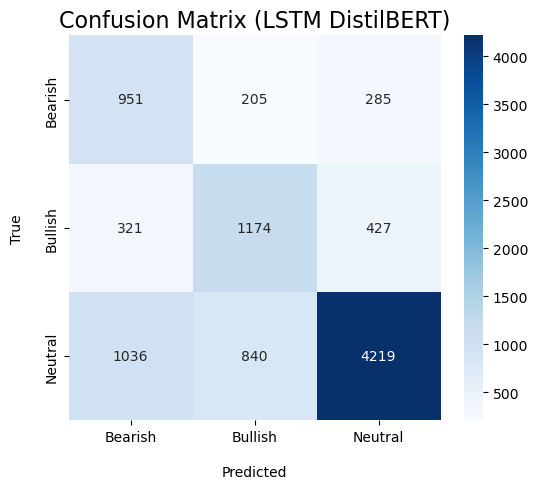

In [40]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM DistilBERT)', fontsize=16)
plt.show()

In [41]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

,fold,epoch,accuracy,loss,val_accuracy,val_loss
0,0,1,0.576791,0.907354,0.707717,0.736885
1,0,2,0.636532,0.811488,0.695560,0.723160
2,0,3,0.661380,0.759152,0.656448,0.780135
3,0,4,0.688739,0.705079,0.677061,0.738006
4,0,5,0.716363,0.647166,0.687632,0.725757


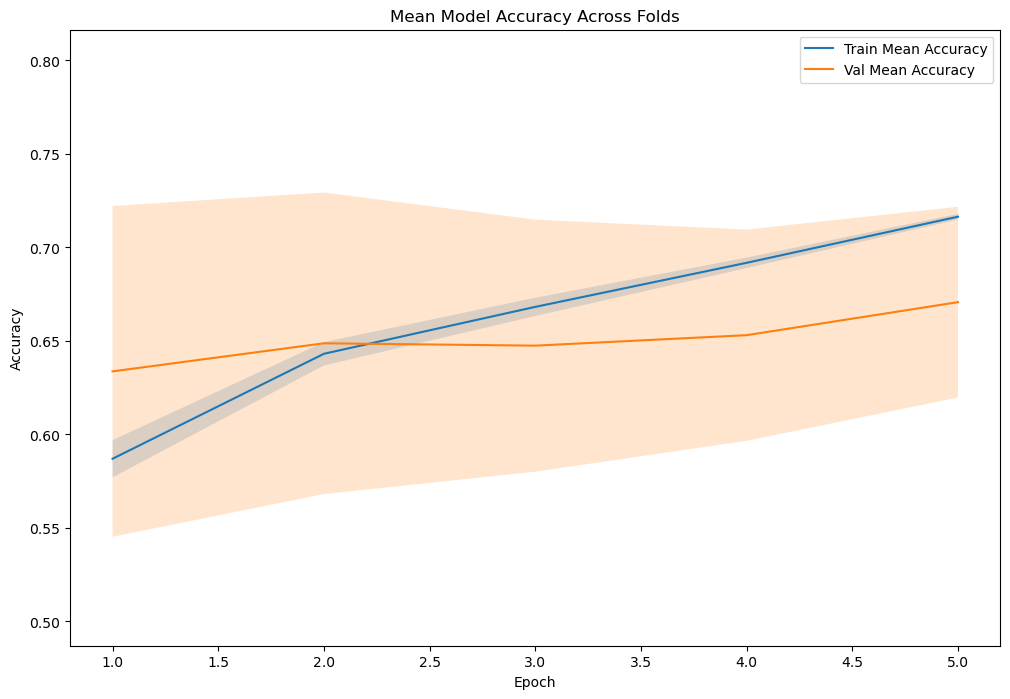

In [42]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### RoBERTa

In [43]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    X_train=X_train,
    y_train=y_train,
    skf=skf,
    emb_method="transformer",
    emb_model=AutoModel.from_pretrained(roberta_model),
    tokenizer=AutoTokenizer.from_pretrained(roberta_model),
    device='cuda'
)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1892/1892 [00:28<00:00, 66.07it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 307ms/step - accuracy: 0.5920 - loss: 0.9443 - val_accuracy: 0.7109 - val_loss: 0.7383
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 280ms/step - accuracy: 0.6814 - loss: 0.7394 - val_accuracy: 0.7040 - val_loss: 0.7251
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 278ms/step - accuracy: 0.6964 - loss: 0.6997 - val_accuracy: 0.7246 - val_loss: 0.6727
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 278ms/step - accuracy: 0.7134 - loss: 0.6681 - val_accuracy: 0.7384 - val_loss: 0.6439
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 66s 277ms/step - accuracy: 0.7263 - loss: 0.6366 - val_accuracy: 0.7236 - val_loss: 0.6563
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step


100%|██████████| 1892/1892 [00:29<00:00, 64.71it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 106s 432ms/step - accuracy: 0.5918 - loss: 0.8642 - val_accuracy: 0.6823 - val_loss: 0.7317
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 96s 404ms/step - accuracy: 0.6965 - loss: 0.7141 - val_accuracy: 0.6792 - val_loss: 0.7383
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 95s 403ms/step - accuracy: 0.7146 - loss: 0.6757 - val_accuracy: 0.7130 - val_loss: 0.6924
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 96s 406ms/step - accuracy: 0.7231 - loss: 0.6460 - val_accuracy: 0.7289 - val_loss: 0.6582
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 95s 403ms/step - accuracy: 0.7404 - loss: 0.6174 - val_accuracy: 0.7299 - val_loss: 0.6572
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step


100%|██████████| 1892/1892 [00:28<00:00, 65.87it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 107s 434ms/step - accuracy: 0.5792 - loss: 0.9008 - val_accuracy: 0.7363 - val_loss: 0.6697
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 96s 404ms/step - accuracy: 0.6725 - loss: 0.7522 - val_accuracy: 0.7394 - val_loss: 0.6362
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 95s 400ms/step - accuracy: 0.6946 - loss: 0.7093 - val_accuracy: 0.7452 - val_loss: 0.6183
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 94s 399ms/step - accuracy: 0.7215 - loss: 0.6702 - val_accuracy: 0.7569 - val_loss: 0.6215
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 94s 399ms/step - accuracy: 0.7357 - loss: 0.6321 - val_accuracy: 0.7500 - val_loss: 0.6249
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step


100%|██████████| 1891/1891 [00:28<00:00, 65.52it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 106s 430ms/step - accuracy: 0.5767 - loss: 0.9166 - val_accuracy: 0.6679 - val_loss: 0.7852
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 95s 402ms/step - accuracy: 0.6715 - loss: 0.7557 - val_accuracy: 0.6520 - val_loss: 0.7901
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 95s 399ms/step - accuracy: 0.6970 - loss: 0.7124 - val_accuracy: 0.6573 - val_loss: 0.7801
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 94s 397ms/step - accuracy: 0.7158 - loss: 0.6815 - val_accuracy: 0.6478 - val_loss: 0.7872
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 94s 399ms/step - accuracy: 0.7278 - loss: 0.6346 - val_accuracy: 0.6785 - val_loss: 0.7428
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step


100%|██████████| 1891/1891 [00:28<00:00, 65.93it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 106s 430ms/step - accuracy: 0.5920 - loss: 0.9127 - val_accuracy: 0.5775 - val_loss: 0.9532
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 96s 403ms/step - accuracy: 0.6728 - loss: 0.7569 - val_accuracy: 0.5621 - val_loss: 1.0166
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 95s 401ms/step - accuracy: 0.6900 - loss: 0.7195 - val_accuracy: 0.5600 - val_loss: 1.0175
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 94s 399ms/step - accuracy: 0.7047 - loss: 0.6914 - val_accuracy: 0.6034 - val_loss: 0.9466
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 94s 397ms/step - accuracy: 0.7188 - loss: 0.6555 - val_accuracy: 0.6129 - val_loss: 0.9264
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step


In [44]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.4952    0.6731    0.5706      1441
     Bullish     0.5297    0.7248    0.6120      1922
     Neutral     0.8725    0.6970    0.7749      6095

    accuracy                         0.6990      9458
   macro avg     0.6324    0.6983    0.6525      9458
weighted avg     0.7453    0.6990    0.7107      9458



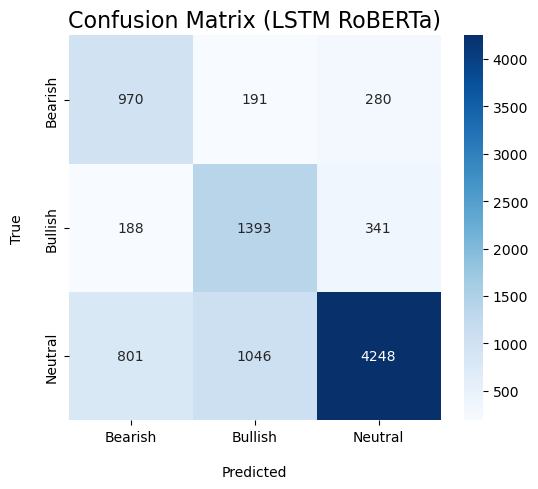

In [45]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM RoBERTa)', fontsize=16)
plt.show()

In [46]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

,fold,epoch,accuracy,loss,val_accuracy,val_loss
0,0,1,0.631774,0.820094,0.710888,0.738264
1,0,2,0.686492,0.720625,0.704017,0.725068
2,0,3,0.703013,0.682761,0.724630,0.672725
3,0,4,0.720063,0.646383,0.738372,0.643888
4,0,5,0.737774,0.610448,0.723573,0.656346


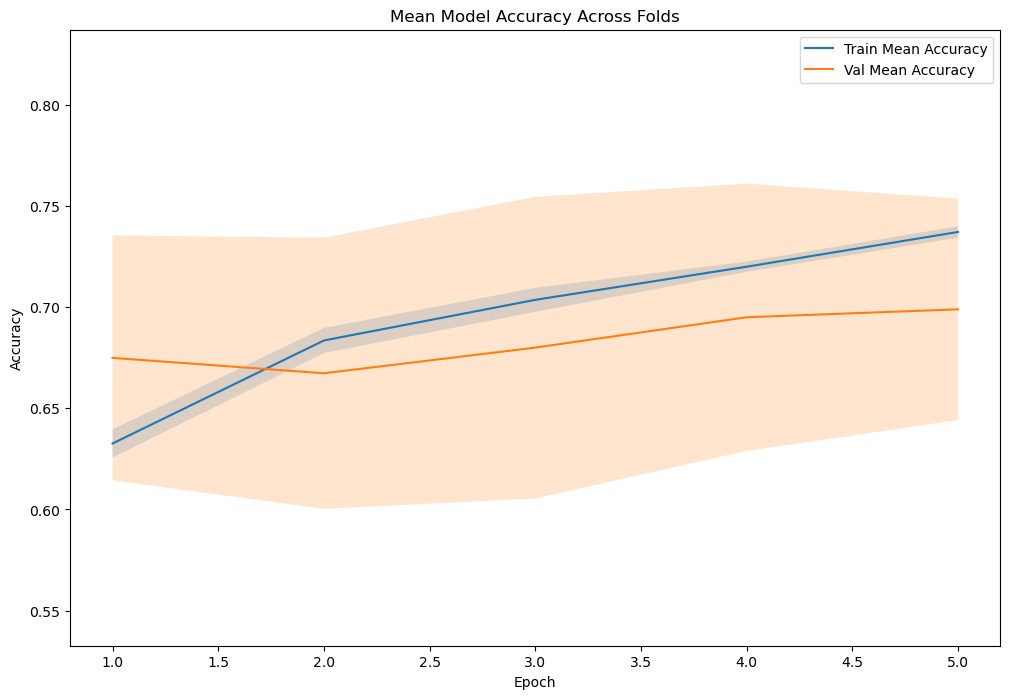

In [47]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### FinBERT

In [48]:
y_true_all, y_pred_all, lstm_history = eval_lstm_model(
    X_train=X_train,
    y_train=y_train,
    skf=skf,
    emb_method="transformer",
    emb_model=AutoModel.from_pretrained(finbert_model),
    tokenizer=AutoTokenizer.from_pretrained(finbert_model),
    device='cuda'
)

100%|██████████| 1892/1892 [00:26<00:00, 70.69it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 282ms/step - accuracy: 0.6172 - loss: 0.8925 - val_accuracy: 0.6818 - val_loss: 0.7431
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 60s 254ms/step - accuracy: 0.7253 - loss: 0.6710 - val_accuracy: 0.7267 - val_loss: 0.6649
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 60s 253ms/step - accuracy: 0.7712 - loss: 0.5651 - val_accuracy: 0.7400 - val_loss: 0.6454
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 60s 252ms/step - accuracy: 0.8330 - loss: 0.4352 - val_accuracy: 0.7458 - val_loss: 0.6813
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 60s 252ms/step - accuracy: 0.8853 - loss: 0.3113 - val_accuracy: 0.7294 - val_loss: 0.7277
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step


100%|██████████| 1892/1892 [00:26<00:00, 70.51it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.6348 - loss: 0.8616 - val_accuracy: 0.6887 - val_loss: 0.7424
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 302ms/step - accuracy: 0.7255 - loss: 0.6562 - val_accuracy: 0.7056 - val_loss: 0.7126
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 300ms/step - accuracy: 0.7794 - loss: 0.5327 - val_accuracy: 0.7294 - val_loss: 0.6828
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 299ms/step - accuracy: 0.8359 - loss: 0.4050 - val_accuracy: 0.7505 - val_loss: 0.7097
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 298ms/step - accuracy: 0.8800 - loss: 0.3050 - val_accuracy: 0.7104 - val_loss: 0.8206
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step


100%|██████████| 1892/1892 [00:26<00:00, 70.59it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.6361 - loss: 0.8744 - val_accuracy: 0.7193 - val_loss: 0.7473
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 301ms/step - accuracy: 0.7172 - loss: 0.6816 - val_accuracy: 0.7315 - val_loss: 0.6960
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 71s 298ms/step - accuracy: 0.7615 - loss: 0.5765 - val_accuracy: 0.7400 - val_loss: 0.6982
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 306ms/step - accuracy: 0.8220 - loss: 0.4498 - val_accuracy: 0.7357 - val_loss: 0.7391
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 314ms/step - accuracy: 0.8701 - loss: 0.3310 - val_accuracy: 0.7209 - val_loss: 0.8425
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step


100%|██████████| 1891/1891 [00:26<00:00, 70.48it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.6176 - loss: 0.9132 - val_accuracy: 0.6425 - val_loss: 0.8181
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 315ms/step - accuracy: 0.7195 - loss: 0.6831 - val_accuracy: 0.6896 - val_loss: 0.7443
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 312ms/step - accuracy: 0.7755 - loss: 0.5718 - val_accuracy: 0.6991 - val_loss: 0.7261
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 311ms/step - accuracy: 0.8225 - loss: 0.4384 - val_accuracy: 0.7446 - val_loss: 0.6645
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 311ms/step - accuracy: 0.8673 - loss: 0.3366 - val_accuracy: 0.7176 - val_loss: 0.8166
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step


100%|██████████| 1891/1891 [00:27<00:00, 69.95it/s]


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.6167 - loss: 0.9028 - val_accuracy: 0.6504 - val_loss: 0.8019
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 315ms/step - accuracy: 0.7107 - loss: 0.6904 - val_accuracy: 0.7028 - val_loss: 0.7146
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 314ms/step - accuracy: 0.7646 - loss: 0.5809 - val_accuracy: 0.6896 - val_loss: 0.7105
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 313ms/step - accuracy: 0.8074 - loss: 0.4672 - val_accuracy: 0.7515 - val_loss: 0.6379
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 312ms/step - accuracy: 0.8589 - loss: 0.3444 - val_accuracy: 0.7229 - val_loss: 0.7389
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step


In [49]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.4908    0.6495    0.5591      1441
     Bullish     0.5595    0.7019    0.6227      1922
     Neutral     0.8807    0.7427    0.8059      6095

    accuracy                         0.7202      9458
   macro avg     0.6437    0.6981    0.6626      9458
weighted avg     0.7561    0.7202    0.7311      9458



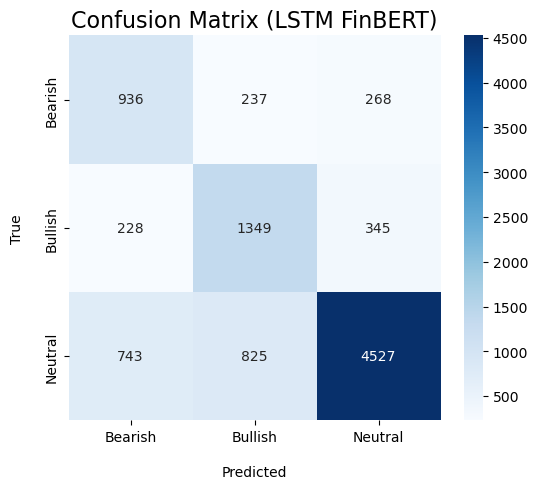

In [50]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (LSTM FinBERT)', fontsize=16)
plt.show()

In [51]:
df_list = []

for fold_idx, history in enumerate(lstm_history):
    df_fold = pd.DataFrame(history.history)
    df_fold['epoch'] = range(1, len(df_fold) + 1)
    df_fold['fold'] = fold_idx  # add fold index column
    # Reorder columns so epoch and fold come first (optional)
    cols = ['fold', 'epoch'] + [col for col in df_fold.columns if col not in ('fold', 'epoch')]
    df_fold = df_fold[cols]
    df_list.append(df_fold)

# Concatenate all folds into a single DataFrame
df_history = pd.concat(df_list, ignore_index=True)

# Show head
df_history.head()

,fold,epoch,accuracy,loss,val_accuracy,val_loss
0,0,1,0.660322,0.799420,0.681818,0.743141
1,0,2,0.728919,0.657068,0.726744,0.664872
2,0,3,0.781126,0.538495,0.739958,0.645435
3,0,4,0.843775,0.407987,0.745772,0.681326
4,0,5,0.882236,0.304478,0.729387,0.727664


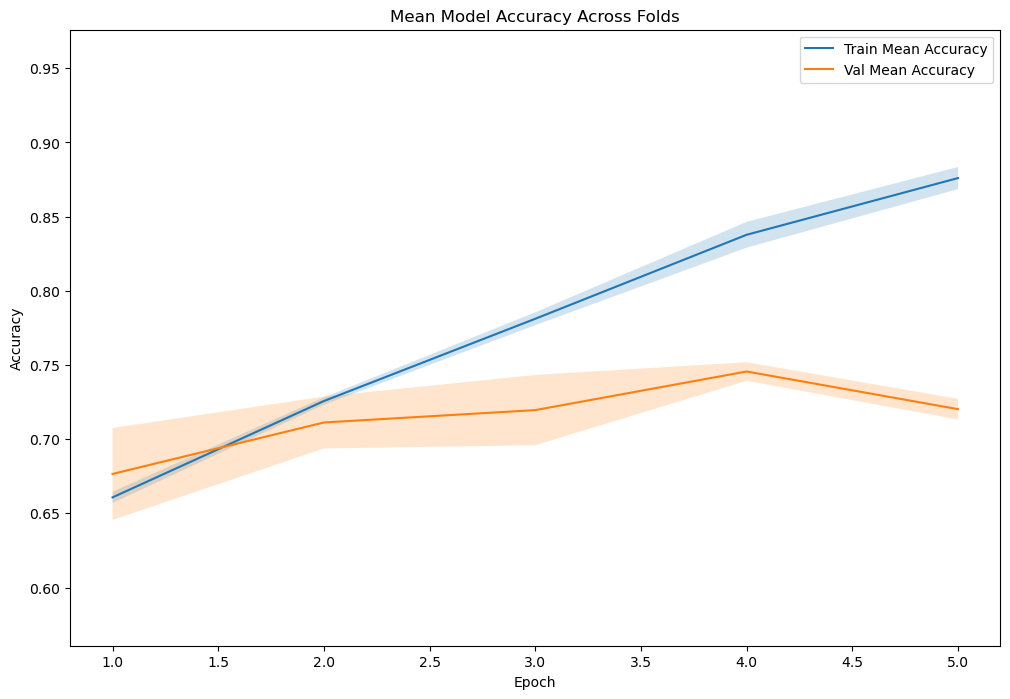

In [52]:
plt.figure(figsize=(12, 8))

epochs = sorted(df_history['epoch'].unique())
train_means = []
val_means = []
train_stds = []
val_stds = []

for epoch in epochs:
    epoch_data = df_history[df_history['epoch'] == epoch]
    train_acc = epoch_data['accuracy']
    val_acc = epoch_data['val_accuracy']
    
    train_means.append(train_acc.mean())
    val_means.append(val_acc.mean())
    train_stds.append(train_acc.std())
    val_stds.append(val_acc.std())

train_means = np.array(train_means)
val_means = np.array(val_means)
train_stds = np.array(train_stds)
val_stds = np.array(val_stds)

plt.plot(epochs, train_means, label='Train Mean Accuracy')
plt.fill_between(epochs, train_means - train_stds, train_means + train_stds, alpha=0.2)

plt.plot(epochs, val_means, label='Val Mean Accuracy')
plt.fill_between(epochs, val_means - val_stds, val_means + val_stds, alpha=0.2)

# Calculate min and max across both train and val means
y_min = min(min(train_means), min(val_means)) - 0.1
y_max = max(max(train_means), max(val_means)) + 0.1

# Prevent y_min from going below 0
y_min = max(y_min, 0)

plt.ylim(y_min, y_max)

plt.title('Mean Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5.3. RoBERTa Encoder

In [68]:
# Evaluate the model
y_true_all, y_pred_all = eval_transformer(
    transformer=roberta_model
    ,objective='sentiment-analysis'
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

Device set to use cuda
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [69]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.4286    0.3352    0.3762      1441
     Bullish     0.5045    0.2352    0.3208      1922
     Neutral     0.6824    0.8325    0.7500      6095

    accuracy                         0.6353      9458
   macro avg     0.5385    0.4676    0.4823      9458
weighted avg     0.6076    0.6353    0.6058      9458



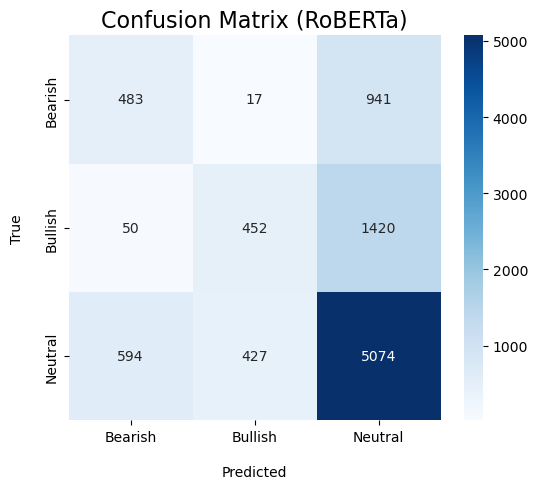

In [70]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (RoBERTa)', fontsize=16)
plt.show()

### 5.4. FinBERT Encoder

In [71]:
# Evaluate the model
y_true_all, y_pred_all = eval_transformer(
    transformer=finbert_model
    ,objective='sentiment-analysis'
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
)

Device set to use cuda
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [72]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

Overall classification report across all folds:

              precision    recall  f1-score   support

     Bearish     0.4950    0.4511    0.4720      1441
     Bullish     0.5223    0.4865    0.5038      1922
     Neutral     0.7594    0.7918    0.7753      6095

    accuracy                         0.6778      9458
   macro avg     0.5923    0.5764    0.5837      9458
weighted avg     0.6710    0.6778    0.6739      9458



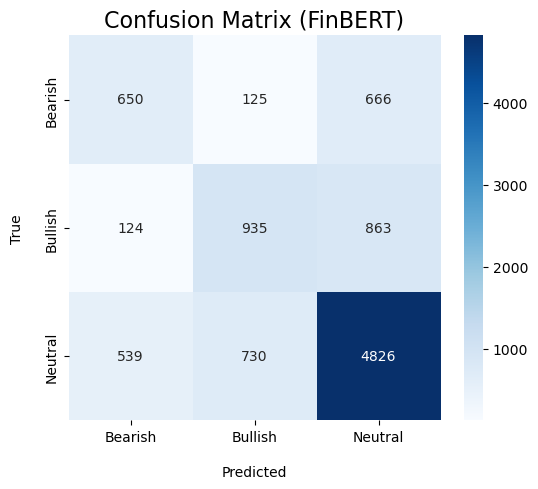

In [73]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (FinBERT)', fontsize=16)
plt.show()

### 5.5. Language Model

In [ ]:
system_message = """
[REASON]
You are a financial sentiment analysis engine.

[TASK]
Analyze the input text ([INPUT]) from financial tweets and classify its sentiment as one of:
  0: Bearish (negative sentiment)
  1: Bullish (positive sentiment)
  2: Neutral (neutral sentiment)

Provide as an answer a single digit in [0, 1, 2]

[EXAMPLE:EXAMPLE OUTPUT]
  "JPMorgan reels in expectations on Beyond Meat": 0
  "Dougherty & Company starts at Buy": 1
  "Analysts React To FCC Decision On Intelsat C-Band Spectrum Auction": 2

[INPUT]
"""

In [ ]:
# Evaluate the model
y_true_all, y_pred_all = eval_llm_model(
    model="tiiuae/falcon-7b-instruct"
    ,skf=skf
    ,X_train=X_train
    ,y_train=y_train
    ,system_message=system_message
)

In [ ]:
print("Overall classification report across all folds:\n")
print(classification_report(y_true_all, y_pred_all, digits=4, target_names=LABELS.keys()))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.keys(), yticklabels=LABELS.keys())
plt.xlabel('Predicted', labelpad=15)
plt.ylabel('True', labelpad=15)
plt.title('Confusion Matrix (Language Model)', fontsize=16)
plt.show()